# Phi-2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from huggingface_hub import notebook_login
import re
from matplotlib import pyplot as plt
from tensorboard import notebook

No Bottleneck unit testing available.


2024-01-27 11:04:27.080604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 11:04:27.080650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 11:04:27.081370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 11:04:27.086306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 11:04:27.877594: W tensorflow/compiler/tf2

## Helper functions

### Prompts

In [3]:
def generate_prompt(data_point):
    return f"""Analyze the sentiment of the sentence enclosed in square brackets, determine if it is happiness or fear or anger or sadness or disgust or shame or guilt or surprise, and return the answer by one word as the corresponding sentiment label 'happiness' or 'fear' or 'anger' or 'sadness' or 'disgust' or 'shame' or'guilt' or 'surprise'.
            [{data_point["preprocessed_text"]}] = {data_point["emotion"]}""".strip()

def generate_test_prompt(data_point):
    return f"""Analyze the sentiment of the sentence enclosed in square brackets, determine if it is happiness or fear or anger or sadness or disgust or shame or guilt or surprise, and return the answer by one word as the corresponding sentiment label 'happiness' or 'fear' or 'anger' or 'sadness' or 'disgust' or 'shame' or'guilt' or 'surprise'.
            [{data_point["preprocessed_text"]}] = """.strip()

### Predict

In [4]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens = 10,
                        temperature = 0.1, 
                        return_full_text=False
                       )
        result = pipe(prompt)
        generated_text = result[0]['generated_text']

        emotion = generated_text.split()[0]
        answer = ''.join([x for x in emotion if x.isalnum()])

        if "happiness" in answer:
            y_pred.append("happiness")
        elif "fear" in answer:
            y_pred.append("fear")
        elif "anger" in answer:
            y_pred.append("anger")
        elif "sadness" in answer:
            y_pred.append("sadness")
        elif "disgust" in answer:
            y_pred.append("disgust")
        elif "shame" in answer:
            y_pred.append("shame")
        elif "guilt" in answer:
            y_pred.append("guilt")
        elif "surprise" in answer:
            y_pred.append("surprise")
        else:
            y_pred.append("none")
    return y_pred
    

### Evaluation

In [26]:
def evaluate(y_true, y_pred):
    labels = ['happiness', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt', 'surprise']
    
    mapping = {
        'happiness': 0,
        'fear': 1,
        'anger': 2,
        'sadness': 3,
        'disgust': 4,
        'shame': 5,
        'guilt': 6,
        'surprise': 7,
    }

    reverse_mapping = {v: k for k, v in mapping.items()}  # Reverse mapping for converting numbers to labels

    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label_num in unique_labels:
        label = reverse_mapping[label_num]
        label_indices = [i for i in range(len(y_true)) if y_true[i] == label_num]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=[reverse_mapping[label_num] for label_num in y_true],
                                         y_pred=[reverse_mapping[label_num] for label_num in y_pred])
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])
    print('\nConfusion Matrix:')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.show()

### Layers

In [6]:
def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []
    
    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

## Data

In [7]:
df = pd.read_csv('full_dataset/full_dataset.csv')
df

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","['period', 'falling', 'love', 'time', 'met', '...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"['involved', 'traffic', 'accident']",involved traffic accident
2,anger,When I was driving home after several days of...,"['driving', 'home', 'several', 'day', 'hard', ...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"['lost', 'person', 'meant']",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"['time', 'knocked', 'deer', 'sight', 'animal',...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9801,shame,He gets real humiliated and has to leave .,"['get', 'real', 'humiliated', 'leave']",get real humiliated leave
9802,shame,They aimed for higher status jobs and felt hum...,"['aimed', 'higher', 'status', 'job', 'felt', '...",aimed higher status job felt humiliated unempl...
9803,shame,He cursed his lack of self-control ; he knew t...,"['cursed', 'lack', 'selfcontrol', 'knew', 'old...",cursed lack selfcontrol knew old biddy seen fe...
9804,shame,Sometimes I've thought I 'll never forget wha...,"['sometimes', 'ive', 'thought', 'never', 'forg...",sometimes ive thought never forget happened co...


In [8]:
data = df[['emotion', 'preprocessed_text']]
data

,emotion,preprocessed_text
0,happiness,period falling love time met especially met lo...
1,fear,involved traffic accident
2,anger,driving home several day hard work motorist ah...
3,sadness,lost person meant
4,disgust,time knocked deer sight animal injury helpless...
...,...,...
9801,shame,get real humiliated leave
9802,shame,aimed higher status job felt humiliated unempl...
9803,shame,cursed lack selfcontrol knew old biddy seen fe...
9804,shame,sometimes ive thought never forget happened co...


In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, test_valid_index in split.split(data, data['emotion']):
    train_set = data.iloc[train_index]
    test_valid_set = data.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set['emotion']):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [10]:
X_train = train_set.reset_index(drop=True)

In [11]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["text"])
X_eval = pd.DataFrame(valid_set.apply(generate_prompt, axis=1),
                      columns=["text"])

In [12]:
y_true = test_set.emotion
X_test = pd.DataFrame(test_set.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

## Model

In [13]:
notebook_login()

In [14]:
model_name = "microsoft/phi-2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
y_pred = predict(X_test, model, tokenizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1961/1961 [18:11<00:00,  1.80it/s]


Accuracy: 0.381
Accuracy for label 0: 0.561
Accuracy for label 1: 0.375
Accuracy for label 2: 0.252
Accuracy for label 3: 0.514
Accuracy for label 4: 0.463
Accuracy for label 5: 0.316
Accuracy for label 6: 0.019
Accuracy for label 7: 0.721

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.56      0.55       310
           1       0.36      0.37      0.36       299
           2       0.60      0.25      0.35       310
           3       0.63      0.51      0.57       323
           4       0.25      0.46      0.32       231
           5       0.40      0.32      0.35       237
           6       1.00      0.02      0.04       208
           7       0.10      0.72      0.18        43

    accuracy                           0.38      1961
   macro avg       0.48      0.40      0.34      1961
weighted avg       0.52      0.38      0.38      1961


Confusion Matrix:


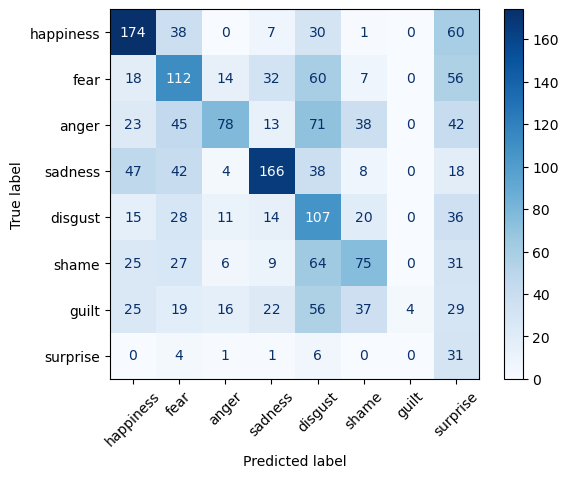

In [16]:
evaluate(y_true, y_pred)

In [17]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=['q_proj',
    'k_proj',
    'v_proj',
    'dense',
    'fc1',
    'fc2',],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir="logsPhi",
    num_train_epochs=10,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # 4
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="epoch"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=512,
)

Map:   0%|          | 0/5883 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

In [18]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("trained-model-phi2")

You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,0.880300,0.701478
1,0.651900,0.707640
2,0.578900,0.674695
3,0.637600,0.686159
4,0.416800,0.702435
5,0.589300,0.730431
6,0.423100,0.759907
8,0.423000,0.791141
9,0.272600,0.793791


In [ ]:
y_pred = predict(X_test, model, tokenizer)

Accuracy: 0.762
Accuracy for label happiness: 0.871
Accuracy for label fear: 0.860
Accuracy for label anger: 0.726
Accuracy for label sadness: 0.799
Accuracy for label disgust: 0.719
Accuracy for label shame: 0.637
Accuracy for label guilt: 0.601
Accuracy for label surprise: 0.977

Classification Report:
              precision    recall  f1-score   support

       anger       0.73      0.73      0.73       310
     disgust       0.74      0.72      0.73       231
        fear       0.85      0.86      0.86       299
       guilt       0.55      0.60      0.58       208
   happiness       0.87      0.87      0.87       310
     sadness       0.83      0.80      0.81       323
       shame       0.64      0.64      0.64       237
    surprise       1.00      0.98      0.99        43

    accuracy                           0.76      1961
   macro avg       0.78      0.77      0.77      1961
weighted avg       0.76      0.76      0.76      1961


Confusion Matrix:


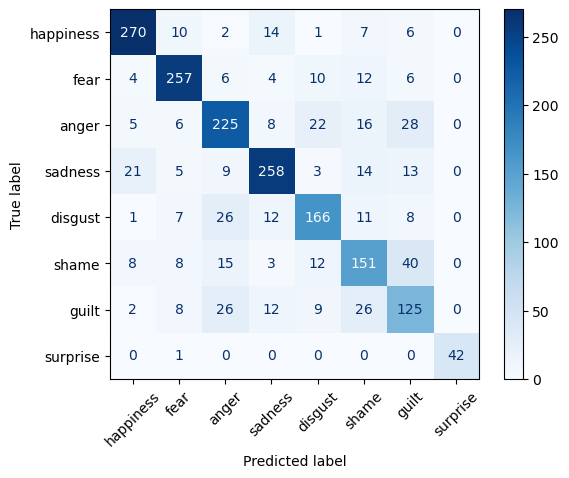

In [28]:
evaluate(y_true, y_pred)

In [20]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions_phi2.csv", index=False)